In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys
sys.path.append("../../../") 

from utils.paths import make_dir_line

modality = 'c'
project = 'Database Design'
data = make_dir_line(modality, project)

raw = data('raw')

In [5]:
import sqlite3

conn = sqlite3.connect(":memory:")  ## aca se indica el nombre de la db.
cur = conn.cursor()

# 7.1.0 Processing, Storing, and Organizing Data

## 7.1.2 OLAP vs. OLTP

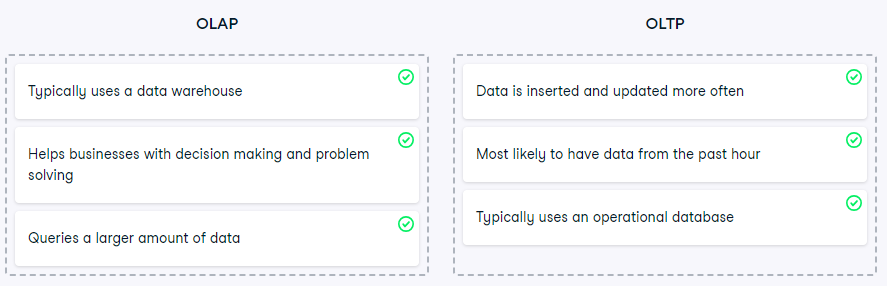

## 7.1.3 Which is better?

Question:  What data processing approach is this larger repository most likely using?


In [10]:
potholes = pd.read_csv(raw / 'potholeschicago.csv', sep = ',', decimal = '.', header = 0, encoding = 'utf-8')
potholes.head()

,CREATION DATE,STATUS,COMPLETION DATE,SERVICE REQUEST NUMBER,TYPE OF SERVICE REQUEST,MOST RECENT ACTION,STREET ADDRESS,ZIP
0,2018-12-17T00:00:00.000,Open,NaN,18-03380123,Pothole in Street,NaN,10300 S WALLACE ST,60628.0
1,2018-12-18T00:00:00.000,Open,NaN,18-03388180,Pothole in Street,NaN,4100 S WESTERN BLVD,60609.0
2,2018-12-18T00:00:00.000,Open,NaN,18-03388493,Pothole in Street,NaN,5230 S NEW ENGLAND AVE,60638.0
3,2018-12-17T00:00:00.000,Open,NaN,18-03386050,Pothole in Street,NaN,1053 E 92ND ST,60619.0
4,2018-12-17T00:00:00.000,Open,NaN,18-03382135,Pothole in Street,NaN,4756 W 85TH ST,60652.0


In [9]:
potholes['SERVICE REQUEST NUMBER'].nunique() == potholes.shape[0]

True

R:/ OLTP because this table's structure appears to require frequest update. This table probably uses an OLTP approach because it is updated and holds data from the past week.



In [7]:
conn.executescript(
    """
    
DROP TABLE IF EXISTS university_professors;

CREATE TABLE university_professors (
  firstname             VARCHAR,
  lastname              VARCHAR,
  university            VARCHAR,
  university_shortname  VARCHAR,
  university_city       VARCHAR,
  function              VARCHAR,
  organization          VARCHAR,
  organization_sector   VARCHAR
);

"""
)
conn.commit()

In [8]:
df = pd.read_csv(raw / 'university_professors.csv', sep = ',', decimal = '.', header = 0, encoding = 'utf-8')
university_professors = list(zip(df.firstname, df.lastname, df.university, df.university_shortname, df.university_city, df.function, df.organization, df.organization_sector))
cur.executemany("INSERT INTO university_professors VALUES  (?,?,?,?,?,?,?,?)", university_professors)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/g/mi unidad/944/courses/Database Design/raw/university_professors.csv'

## 6.1.2 Attributes of relational databases

Which of the following statements does **not** hold true for databases? Relational databases

R:/ are called "relational" because they store data only about people.

## 6.1.3 Query information_schema with SELECT

In [ ]:
# -- Query the right table in information_schema, Specify the correct table_schema value (SQLite3)
cur.execute("""
            
            SELECT name, sql 
            FROM sqlite_master
            WHERE type='table'
            ORDER BY name;
                        
            """).fetchall()

[('university_professors',
  'CREATE TABLE university_professors (\n  firstname             VARCHAR,\n  lastname              VARCHAR,\n  university            VARCHAR,\n  university_shortname  VARCHAR,\n  university_city       VARCHAR,\n  function              VARCHAR,\n  organization          VARCHAR,\n  organization_sector   VARCHAR\n)')]

Question: How many columns does the table university_professors have?

R:/ 8

In [ ]:
# -- Query the first five rows of our table
cur.execute("""
            
            SELECT * 
            FROM university_professors 
            LIMIT 5;
                        
            """).fetchall()

[('Karl',
  'Aberer',
  'ETH Lausanne',
  'EPF',
  'Lausanne',
  'Chairman of L3S Advisory Board',
  'L3S Advisory Board',
  'Education & research'),
 ('Karl',
  'Aberer',
  'ETH Lausanne',
  'EPF',
  'Lausanne',
  'Member Conseil of Zeno-Karl Schindler Foundation',
  'Zeno-Karl Schindler Foundation',
  'Education & research'),
 ('Karl',
  'Aberer',
  'ETH Lausanne',
  'EPF',
  'Lausanne',
  'Member of Conseil Fondation IDIAP',
  'Fondation IDIAP',
  'Education & research'),
 ('Karl',
  'Aberer',
  'ETH Lausanne',
  'EPF',
  'Lausanne',
  'Panel Member ',
  'SNF Ambizione Program',
  'Education & research'),
 ('Reza Shokrollah',
  'Abhari',
  'ETH Zürich',
  'ETH',
  'Zurich',
  'Aufsichtsratsmandat',
  'PNE Wind AG',
  'Energy, environment & mobility')]

## 6.1.4 CREATE your first few TABLEs

Notas: Esto siguiente se puede resolver con un unico conn.executescript

In [ ]:
cur.execute("""
            
            DROP TABLE IF EXISTS professors;
                        
            """).fetchall()

[]

In [ ]:
# -- Create a table for the professors entity type

cur.execute("""
            
            CREATE TABLE professors (
                firstname text,
                lastname text
            );
                        
            """).fetchall()

[]

In [ ]:
# -- Print the contents of this table
cur.execute("""
            
            SELECT * 
            FROM professors
                        
            """).fetchall()

[]

In [ ]:
cur.execute("""
            
            DROP TABLE IF EXISTS universities;
                        
            """).fetchall()

[]

In [ ]:
# -- Create a table for the universities entity type

cur.execute("""
            
            CREATE TABLE universities (
                university_shortname text,
                university           text,
                university_city      text
            );
                        
            """).fetchall()

[]

In [ ]:
# -- Print the contents of this table
cur.execute("""
            
            SELECT * 
            FROM universities
                        
            """).fetchall()

[]

## 6.1.5 ADD a COLUMN with ALTER TABLE

In [ ]:
# -- Add the university_shortname column
cur.execute("""
                        
            ALTER TABLE professors
            ADD COLUMN university_shortname text;

            """).fetchall()

[]

In [ ]:
# -- Print the contents of this table
cur.execute("""
                        
            SELECT * 
            FROM professors

            """).fetchall()

[]

## 6.1.7 RENAME and DROP COLUMNs in affiliations

In [ ]:
cur.execute("DROP TABLE IF EXISTS organizations;").fetchall()

[]

In [ ]:
cur.execute("""
            
            CREATE TABLE organizations (
                organization        text,
                organization_sector text
            );
                        
            """).fetchall()

[]

In [ ]:
cur.execute("DROP TABLE IF EXISTS affiliations;").fetchall()

[]

In [ ]:
cur.execute("""
            
            CREATE TABLE affiliations (
                firstname             text,
                lastname              text,
                university_shortname  text,
                function              text,
                organisation          text
            );
                        
            """).fetchall()

[]

In [ ]:
# -- Rename the organisation column
cur.execute("""
            
            ALTER TABLE affiliations
            RENAME COLUMN organisation TO organization;
                        
            """).fetchall()

[]

In [ ]:
# -- Delete the university_shortname column
cur.execute("""
            
            ALTER TABLE affiliations
            DROP COLUMN university_shortname;
                        
            """).fetchall()

[]

## 6.1.8 Migrate data with INSERT INTO SELECT DISTINCT

In [ ]:
# -- Insert unique professors into the new table
cur.execute("""
            
            INSERT INTO professors 
            SELECT DISTINCT firstname, lastname, university_shortname 
            FROM university_professors;

            """).fetchall()

[]

In [ ]:
# -- Doublecheck the contents of professors
cur.execute("""
            
            SELECT * 
            FROM professors;

            """).fetchall()

[('Karl', 'Aberer', 'EPF'),
 ('Reza Shokrollah', 'Abhari', 'ETH'),
 ('Georges', 'Abou Jaoudé', 'EPF'),
 ('Hugues', 'Abriel', 'UBE'),
 ('Daniel', 'Aebersold', 'UBE'),
 ('Christoph', 'Aebi', 'UBE'),
 ('Marcelo', 'Aebi', 'ULA'),
 ('Patrick', 'Aebischer', 'EPF'),
 ('Stephan', 'Aier', 'USG'),
 ('Anastasia', 'Ailamaki', 'EPF'),
 ('Cesla', 'Amarelle', 'UNE'),
 ('Manuel', 'Ammann', 'USG'),
 ('Christophe', 'Ancey', 'EPF'),
 ('Marilyne', 'Andersen', 'EPF'),
 ('Jean-Marie', 'Annoni', 'UFR'),
 ('John', 'Antonakis', 'ULA'),
 ('Omid', 'Aschari', 'USG'),
 ('David', 'Atienza Alonso', 'EPF'),
 ('Jean-Jacques', 'Aubert', 'UNE'),
 ('Drahomir', 'Aujesky', 'UBE'),
 ('Johan', 'Auwerx', 'EPF'),
 ('François', 'Avellan', 'EPF'),
 ('Kay Werner', 'Axhausen', 'ETH'),
 ('Philippe', 'Bacchetta', 'ULA'),
 ('Andrea', 'Back', 'USG'),
 ('Marco', 'Bakker', 'EPF'),
 ('Artur', 'Baldauf', 'UBE'),
 ('Christophe', 'Ballif', 'EPF'),
 ('Yann', 'Barrandon', 'ULA'),
 ('David Andrew', 'Barry', 'EPF'),
 ('Pius Eliseo', 'Baschera',

In [ ]:
# -- Insert unique affiliations into the new table
cur.execute("""
            
            INSERT INTO affiliations 
            SELECT DISTINCT firstname, lastname, function, organization 
            FROM university_professors;

            """).fetchall()

[]

In [ ]:
# -- Doublecheck the contents of affiliations
cur.execute("""
            
            SELECT * 
            FROM affiliations;

            """).fetchall()

[('Karl', 'Aberer', 'Chairman of L3S Advisory Board', 'L3S Advisory Board'),
 ('Karl',
  'Aberer',
  'Member Conseil of Zeno-Karl Schindler Foundation',
  'Zeno-Karl Schindler Foundation'),
 ('Karl', 'Aberer', 'Member of Conseil Fondation IDIAP', 'Fondation IDIAP'),
 ('Karl', 'Aberer', 'Panel Member ', 'SNF Ambizione Program'),
 ('Reza Shokrollah', 'Abhari', 'Aufsichtsratsmandat', 'PNE Wind AG'),
 ('Georges',
  'Abou Jaoudé',
  "Professeur invité (2 interventions d'une semaine)",
  'Kazan Federal University, Russia'),
 ('Hugues', 'Abriel', None, 'Cloetta Stiftung'),
 ('Daniel', 'Aebersold', None, 'Berner Radium-Stiftung'),
 ('Daniel', 'Aebersold', None, 'Janser Krebs-Stiftung'),
 ('Daniel', 'Aebersold', None, 'SWAN Isotopen AG'),
 ('Christoph',
  'Aebi',
  None,
  'Bernische Stiftung für krebskranke Kinder und Jugendliche'),
 ('Christoph', 'Aebi', None, 'Ronald McDonald Stiftung'),
 ('Marcelo', 'Aebi', None, 'Activités académiques'),
 ('Patrick',
  'Aebischer',
  'Beirat',
  'Singapore

## 6.1.9 Delete tables with DROP TABLE

In [ ]:
# -- Delete the university_professors table
cur.execute("""
            
            DROP TABLE university_professors;

            """).fetchall()

[]

In [ ]:
cur.execute("""
            
            SELECT name, sql 
            FROM sqlite_master
            WHERE type='table'
            ORDER BY name;
                        
            """).fetchall()

[('affiliations',
  'CREATE TABLE affiliations (\n                firstname             text,\n                lastname              text,\n                function              text,\n                organization          text\n            )'),
 ('organizations',
  'CREATE TABLE organizations (\n                organization        text,\n                organization_sector text\n            )'),
 ('professors',
  'CREATE TABLE professors (\n                firstname text,\n                lastname text\n            , university_shortname text)'),
 ('universities',
  'CREATE TABLE universities (\n                university_shortname text,\n                university           text,\n                university_city      text\n            )')]

In [ ]:
print('Ok_')

Ok_
